# Part a: Gaussian Generative Model

## Import libraries

In [26]:

import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy.linalg import slogdet, inv
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd


## Data preprocessing

In [3]:
digits = sklearn.datasets.load_digits()
## load the digits dataset from sklearn
X = digits.data
y = digits.target

## Create a 70% / 15% / 15% split:
X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

##  standardize the features
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)


### 1. compute class priors pi_k

In [ ]:
#pi_k = P(y=k)
K= 10
N= X_train.shape[0] 
pi = np.zeros(K)
for k in range(K):
    pi[k] = np.sum(y_train == k) / N

print("Class priors:", pi)

Class priors: [0.09864757 0.10103421 0.09864757 0.10182975 0.10103421 0.10103421
 0.10103421 0.09944312 0.09705648 0.10023866]


### 2. compute class means mu_k

In [ ]:
# mu_k = E[x|y=k]
D= X_train.shape[1]
mu = np.zeros((K,D))
for k in range(K):
    mu[k] = np.mean(X_train[y_train == k], axis=0) # x given y=k 

print("Class means shape:", mu.shape)

Class means shape: (10, 64)


### 3. compute shared covariance Σ

In [ ]:
# sigma= 1/n * sum_i (x_i - mu_(y_i))(x_i - mu_(y_i))^T
sigma = np.zeros((D,D))
for i in range(N):
    diff= (X_train[i] - mu[y_train[i]])[:,None] # make it a column vector (D x 1)
    sigma += diff.dot(diff.T)
sigma /= N
print("Shared covariance shape:", sigma.shape, " trace:", np.trace(sigma)) #trace is sum of diagonal elements

Shared covariance shape: (64, 64)  trace: 41.085022049776384


### 4. regularise Σ

In [9]:
# Σ_λ= Σ + λI
lambda_reg = 1e-3
sigma_reg = sigma + lambda_reg * np.eye(D)
print("Regularized covariance shape:", sigma_reg.shape, " trace:", np.trace(sigma_reg))

Regularized covariance shape: (64, 64)  trace: 41.14902204977638


### 5. computing log Gaussian scores

In [11]:
# we assume p(x|y=k) ~ N(x;mu_k, Σ_λ) and p(y=k) = pi_k
# What we calculate is posterior score of sample x for class k = log p(y=k) + log p(x|y=k) <------- important
# log p(x|y=k) = -0.5 * [ D log(2pi) + log|Σ_λ| + (x - mu_k)^T Σ_λ^-1 (x - mu_k) ] from the multivariate normal distribution
# the term -0.5 * D log(2pi)- 0.5 * log|Σ_λ| is constant for all classes, so we can ignore it in the score computation

def compute_scores(X):
    N= X.shape[0]
    D= X.shape[1]
    K= mu.shape[0]
    scores= np.zeros((N,K))
    sign, logdet= slogdet(sigma_reg)
    if sign <= 0:
        raise ValueError("Covariance matrix is not positive definite.")
    sigma_inv= inv(sigma_reg)
    const_term= -0.5 * (D * np.log(2*np.pi) + logdet) # constant term for all classes
    for k in range(K):
        diff= X - mu[k] 
        for i in range(N):
            mahalanobis= diff[i].T.dot(sigma_inv).dot(diff[i])
            log_likelihood= const_term - 0.5 * mahalanobis
            scores[i,k]= np.log(pi[k]) + log_likelihood
    return scores

# for each sample in X, compute scores and predict the class with highest score


### Functions to predict and calculate accuracy

In [12]:
def predict_from_scores(scores):
    return np.argmax(scores, axis=1)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


## Hyperparameter Tuning and Evaluation 

In [27]:
lambdas= [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
best_acc = -np.inf
best_lam = None
lambdas_table= []

for lambda_reg in lambdas:
    sigma_reg = sigma + lambda_reg * np.eye(D)
    scores_val= compute_scores(X_val)
    y_val_pred= predict_from_scores(scores_val)
    acc= accuracy(y_val, y_val_pred)
    if acc> best_acc:
        best_acc=acc
        best_lam=lambda_reg
    lambdas_table.append((lambda_reg, acc))
    
lambdas_df= pd.DataFrame(lambdas_table, columns=['Lambda', 'Validation Accuracy'])
print(lambdas_df)
print("\nbest lambda:", best_lam, "val acc:", best_acc)


    Lambda  Validation Accuracy
0   0.0001             0.944444
1   0.0010             0.944444
2   0.0100             0.944444
3   0.1000             0.944444
4   1.0000             0.922222
5  10.0000             0.848148

best lambda: 0.0001 val acc: 0.9444444444444444


### Final Model

In [18]:
# combine train and val sets for final evaluation
X_combined= np.vstack((X_train, X_val))
y_combined= np.hstack((y_train, y_val))
N_combined= X_combined.shape[0]
lambda_reg = best_lam
sigma_reg = sigma + lambda_reg * np.eye(D)
scores_final= compute_scores(X_combined)
y_final_pred= predict_from_scores(scores_final)
final_acc= accuracy(y_combined, y_final_pred)
print(f"\nFinal accuracy on combined train+val set with lambda={best_lam}: {final_acc*100:.2f}%")


Final accuracy on combined train+val set with lambda=0.0001: 96.46%


### Metrics

In [ ]:
print("Test accuracy evaluation: ",f"{final_acc*100:.2f}%")
print("Macro averaged precision: ",f"{precision_score(y_combined, y_final_pred, average='macro')*100:.2f}%")
print("Macro averaged recall: ",f"{recall_score(y_combined, y_final_pred, average='macro')*100:.2f}%")
print("Macro averaged F1-score: ",f"{f1_score(y_combined, y_final_pred, average='macro')*100:.2f}%")
print("Confusion Matrix:\n", confusion_matrix(y_combined, y_final_pred))

Test accuracy evaluation:  96.46%
Macro averaged precision:  96.52%
Macro averaged recall:  96.46%
Macro averaged F1-score:  96.48%
Confusion Matrix:
 [[150   0   0   0   0   0   1   0   0   0]
 [  0 146   1   0   1   0   0   0   2   4]
 [  0   0 148   3   0   0   0   0   0   0]
 [  0   0   1 149   0   1   0   0   3   1]
 [  0   1   0   0 149   0   0   1   2   1]
 [  0   0   0   0   0 147   1   0   0   7]
 [  0   2   0   0   1   0 151   0   0   0]
 [  0   0   0   0   0   0   0 150   0   2]
 [  0   6   0   0   0   0   0   1 139   2]
 [  0   0   0   1   0   1   0   2   5 144]]


## Comments

In [29]:
# short explanation of the Gaussian Generative Model , parameter estimation and regularization.
# Gaussian Generative Model:
# - We assume each class y=k has a prior probability π_k = p(y=k), estimated from the fraction of training samples in that class.
# - The class-conditional distribution p(x | y=k) is multivariate Gaussian: x | y=k ~ N(μ_k, Σ), 
#   where μ_k is the mean vector for class k and Σ is a shared covariance matrix across all classes.
# Parameter estimation:
# - π_k: proportion of training samples in class k.
# - μ_k: average of all training samples belonging to class k.
# - Σ: accumulated outer product of deviations (x_i - μ_{y_i})(x_i - μ_{y_i})^T over all samples, divided by total number of samples.
# Regularization:
# - To ensure numerical stability and invertibility, we use Σ_λ = Σ + λI.
# - λ > 0 prevents singular matrices and smooths the covariance; larger λ produces more “spherical” distributions.

In [28]:
# Discussion:
# The confusion matrix shows that certain digits are more frequently confused with each other, 
# particularly visually similar ones. For example, digits 1 and 7, or 3 and 8, are commonly misclassified, 
# while digits like 0, 4, and 6 are recognized very accurately. These confusions reflect the inherent similarity 
# in pixel patterns for these digits.

# The choice of λ had a clear effect on performance. Small λ values can lead to overfitting, making the model 
# sensitive to noise in the training set, while very large λ oversmooths the covariance and reduces separation 
# between classes. Overall, the Gaussian generative model is fast, interpretable, and works well for distinct 
# digits, but its assumption of a shared covariance limits its ability to capture class-specific feature correlations, 
# and it struggles with overlapping or non-Gaussian patterns in the data.

# Part b: Naïve Bayes

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

## Data preprocessing

In [3]:
# 1 - LOADING THE DATA SET

path = "C:\\Users\\ghane\\Downloads\\adult.csv\\adult.csv"
df = pd.read_csv(path, skipinitialspace=True)


# 2 - SELECTING THE FEATURES

categorical_features = [
    "workclass", "education", "marital.status", "occupation",
    "relationship", "race", "sex", "native.country"
]
target_column = "income"

# check if all columns are present
for c in categorical_features + [target_column]:
    if c not in df.columns:
        raise ValueError(f"Column missing: {c}")

df_categorial = df[categorical_features + [target_column]].copy()


# 3 - CLEANING MISSING VALUES

for f in categorical_features:
    df_categorial[f] = df_categorial[f].fillna("Unkown").astype(str).str.strip()
    df_categorial[f] = df_categorial[f].replace("?", "Unkown")


# 4 - ENCODING FEATURES

dictionary = {}
X = pd.DataFrame()
for f in categorical_features:
    s = pd.Categorical(df_categorial[f])
    mapping = {category: i for i, category in enumerate(s.categories)}
    dictionary[f] = mapping
    X[f] = s.codes.astype(int)

Y = df_categorial[target_column].map({"<=50K": 0, ">50K": 1})


# 5 - TRAIN/VALIDATION/TEST SPLIT

X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, test_size=0.15, stratify=Y, random_state=42
)
val_ratio = 0.15 / 0.85
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=val_ratio, stratify=Y_temp, random_state=42
)


## 1. Naive bayes class

In [4]:
class NaiveBayesCategorical:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.likelihoods = {}
        self.classes = None

    def fit(self, X, Y):
        self.classes = np.unique(Y)
        n_samples, n_features = X.shape
        class_count = Y.value_counts()
        n_classes = len(self.classes)

        # calculate class priors with Laplace smoothing
        self.class_priors = {
            c: (class_count.get(c, 0) + self.alpha) / (n_samples + self.alpha * n_classes)
            for c in self.classes
        }

        # calculate likelihoods for each feature given each class
        for f in X.columns:
            self.likelihoods[f] = {}
            for c in self.classes:
                X_c = X[Y == c]
                value_counts = X_c[f].value_counts().to_dict()
                n_values = len(X[f].unique())
                self.likelihoods[f][c] = {
                    k: (value_counts.get(k, 0) + self.alpha) / (len(X_c) + self.alpha * n_values)
                    for k in X[f].unique()
                }

    def predict_proba(self, X):
        proba = []
        for _, row in X.iterrows():
            class_probs = {}
            for c in self.classes:
                prob = self.class_priors[c]
                for f in X.columns:
                    prob *= self.likelihoods[f][c].get(
                        row[f],
                        self.alpha / (self.alpha * len(self.likelihoods[f][c]) + 1)
                    )
                class_probs[c] = prob
            # normalize
            total = sum(class_probs.values())
            for k in class_probs:
                class_probs[k] /= total
            proba.append(class_probs)
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        predictions = [max(p, key=p.get) for p in proba]
        return np.array(predictions)

## 2. Fit model

In [5]:
nb = NaiveBayesCategorical(alpha=1.0)
nb.fit(X_train, Y_train)
y_val_pred = nb.predict(X_val)
accuracy = (y_val_pred == Y_val.values).mean()
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.7925880425880426


## 3. Analysis


--- Smoothing Parameter (alpha) Test ---
Alpha=0.1 -> Validation Accuracy: 0.7932
Alpha=0.5 -> Validation Accuracy: 0.7932
Alpha=1.0 -> Validation Accuracy: 0.7926
Alpha=2.0 -> Validation Accuracy: 0.7922
Alpha=5.0 -> Validation Accuracy: 0.7922

--- Feature Selection Analysis ---
Features=['education', 'occupation'] -> Validation Accuracy: 0.7809
Features=['workclass', 'education', 'marital.status'] -> Validation Accuracy: 0.8227
Features=['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country'] -> Validation Accuracy: 0.7926

--- Probability Distribution Example ---
Example predicted probabilities for first 5 samples:
[[0.15670816 0.84329184]
 [0.15982106 0.84017894]
 [0.4920622  0.5079378 ]
 [0.9793634  0.0206366 ]
 [0.99555899 0.00444101]]


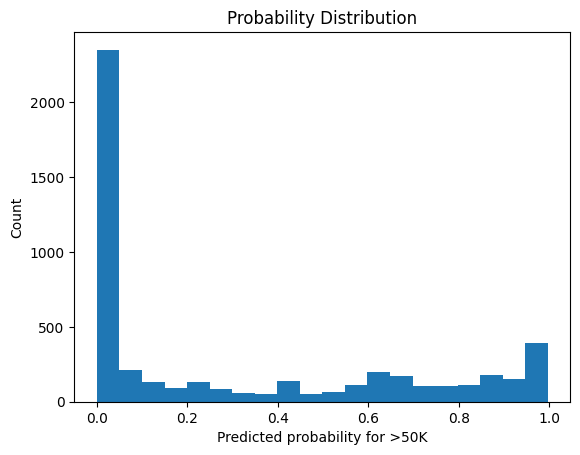


--- Independence Assumption ---
Naive Bayes assumes features are independent given the class. In reality, features like education and occupation are correlated, which may make probabilities slightly biased.


In [6]:
# 1 - Smoothing Parameter Test
print("\n--- Smoothing Parameter (alpha) Test ---")
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0]
for a in alpha_values:
    nb_a = NaiveBayesCategorical(alpha=a)
    nb_a.fit(X_train, Y_train)
    y_val_pred = nb_a.predict(X_val)
    acc = (y_val_pred == Y_val.values).mean()
    print(f"Alpha={a} -> Validation Accuracy: {acc:.4f}")

# 2 - Feature Selection
print("\n--- Feature Selection Analysis ---")
feature_subsets = [
    ["education", "occupation"],
    ["workclass", "education", "marital.status"],
    categorical_features
]
for subset in feature_subsets:
    nb_feat = NaiveBayesCategorical(alpha=1.0)
    nb_feat.fit(X_train[subset], Y_train)
    y_val_pred = nb_feat.predict(X_val[subset])
    acc = (y_val_pred == Y_val.values).mean()
    print(f"Features={subset} -> Validation Accuracy: {acc:.4f}")

# 3 - Probability Analysis
print("\n--- Probability Distribution Example ---")
proba_val = nb.predict_proba(X_val)
proba_array = np.array([[p[0], p[1]] for p in proba_val])
print("Example predicted probabilities for first 5 samples:")
print(proba_array[:5])
plt.hist(proba_array[:, 1], bins=20)
plt.xlabel("Predicted probability for >50K")
plt.ylabel("Count")
plt.title("Probability Distribution")
plt.show()

# 4 - Independence Assumption
print("\n--- Independence Assumption ---")
print("Naive Bayes assumes features are independent given the class. In reality, features like education and occupation are correlated, which may make probabilities slightly biased.")

## 4. Comparison

In [7]:
# 5 - Compare with sklearn's MultinomialNB
print("\n--- Sklearn MultinomialNB Comparison ---")
mnb = MultinomialNB(alpha=1.0)
mnb.fit(X_train, Y_train)
y_val_pred_skl = mnb.predict(X_val)
acc_skl = (y_val_pred_skl == Y_val.values).mean()
print("Sklearn MultinomialNB Validation Accuracy:", acc_skl)


--- Sklearn MultinomialNB Comparison ---
Sklearn MultinomialNB Validation Accuracy: 0.7516380016380017
